In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

/home/kalpesh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kalpesh/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/kalpesh/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=Futur

In [2]:
df = pd.read_csv('Data/clean_data.csv')
df = df.reindex(np.random.permutation(df.index))
df['tweet']=df['cleanText'].astype(str)

In [3]:
df.head()

,tweet_id,cleanText,sentiment,tweet
4559,768,google launch major new social network called circle possibly today updated link,1,google launch major new social network called circle possibly today updated link
770,4135,spark selected finalist team android choice award austin please come amp support link,2,spark selected finalist team android choice award austin please come amp support link
7160,1781,ipad also cartoonishly large digital camera cstejas link,2,ipad also cartoonishly large digital camera cstejas link
6015,2327,nicoriccelli google launch major new social network called circle link google denies,1,nicoriccelli google launch major new social network called circle link google denies
5288,99,gsd amp amp google industry party tonight see u link austin welivehere gsdm,1,gsd amp amp google industry party tonight see u link austin welivehere gsdm


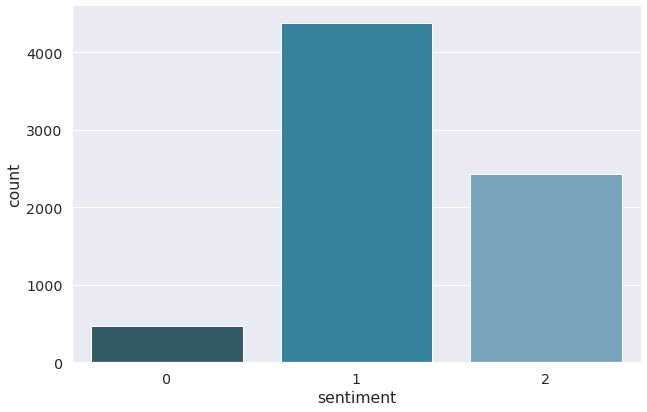

In [4]:
sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [5]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.tweet)
df_eda['sentiment'] = df.sentiment

In [6]:
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment
4559,12,0,0,0,0,0,0,1
770,13,0,0,0,0,0,0,2
7160,8,0,0,0,0,0,0,2
6015,12,0,0,0,0,0,0,1
5288,13,0,0,0,0,0,0,1


In [7]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
            count       mean       std  min  25%   50%   75%   max
sentiment                                                         
0          472.0   10.254237  3.104511  3.0  8.0  10.0  12.0  18.0
1          4374.0  9.874028   3.074708  1.0  8.0  10.0  12.0  21.0
2          2428.0  10.139209  3.047282  2.0  8.0  10.0  12.0  20.0


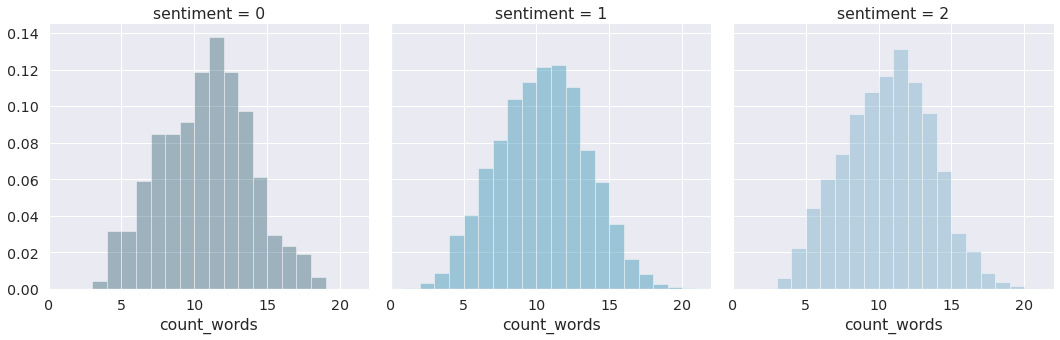

Descriptive stats for count_mentions
------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          472.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4374.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
2          2428.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


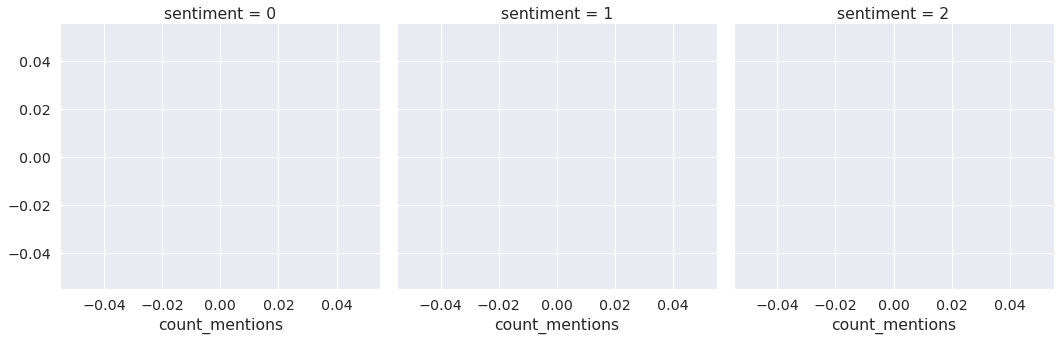

Descriptive stats for count_hashtags
------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          472.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4374.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
2          2428.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


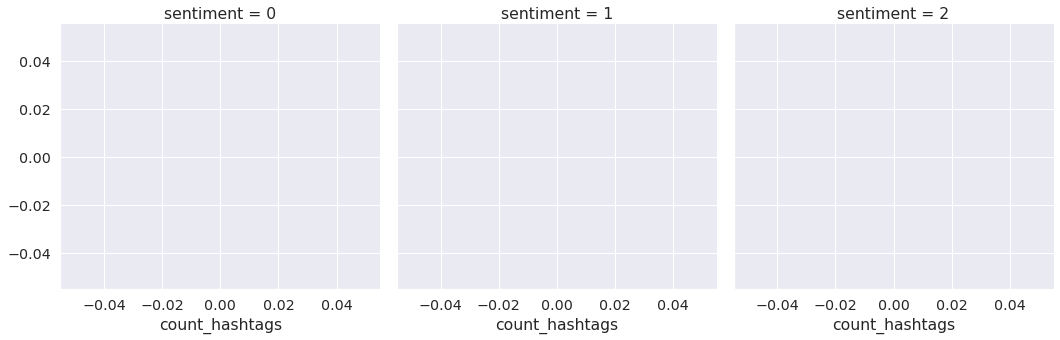

Descriptive stats for count_capital_words
-----------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          472.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4374.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
2          2428.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


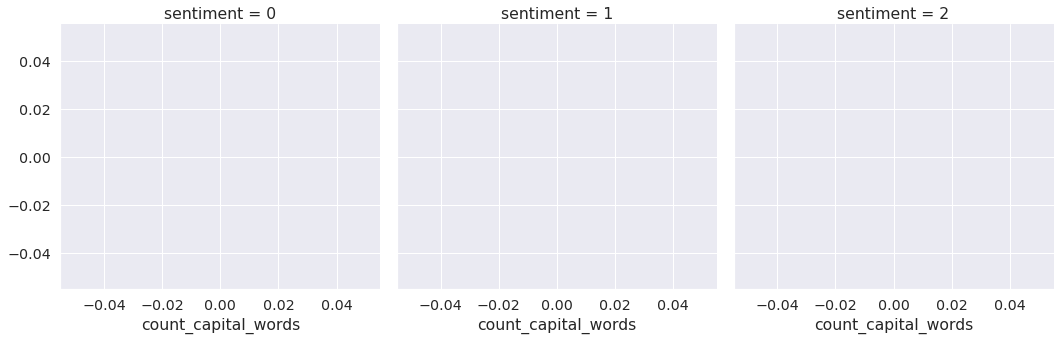

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          472.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4374.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
2          2428.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


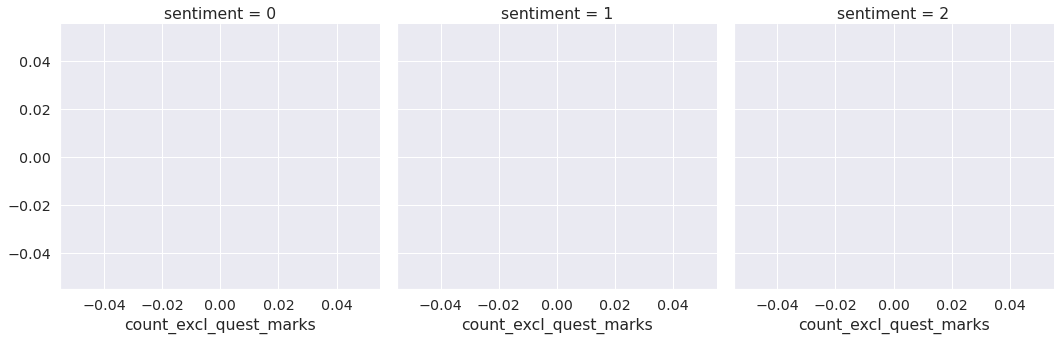

Descriptive stats for count_urls
--------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          472.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4374.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
2          2428.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


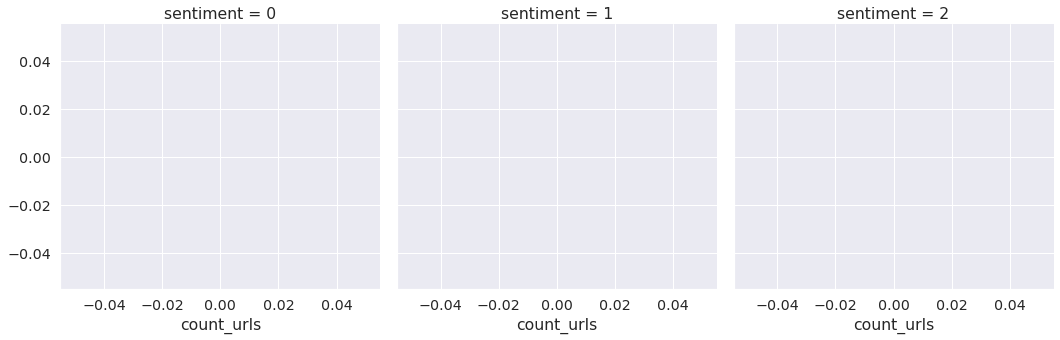

Descriptive stats for count_emojis
----------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          472.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4374.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
2          2428.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


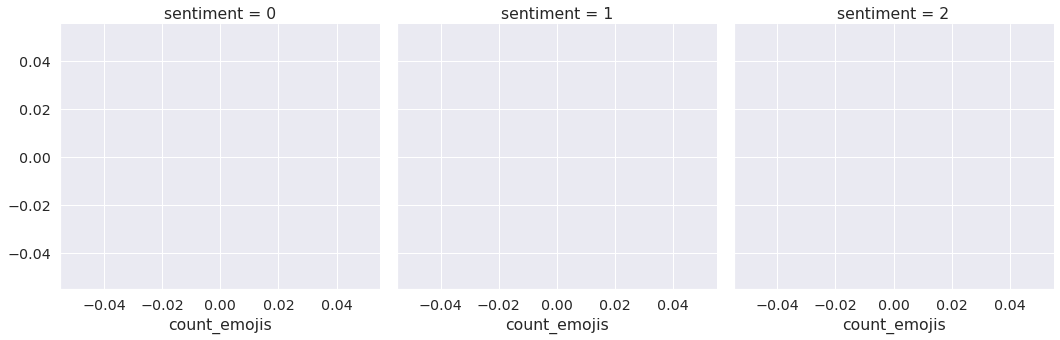

Descriptive stats for sentiment
-------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          472.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4374.0  1.0   0.0  1.0  1.0  1.0  1.0  1.0
2          2428.0  2.0   0.0  2.0  2.0  2.0  2.0  2.0


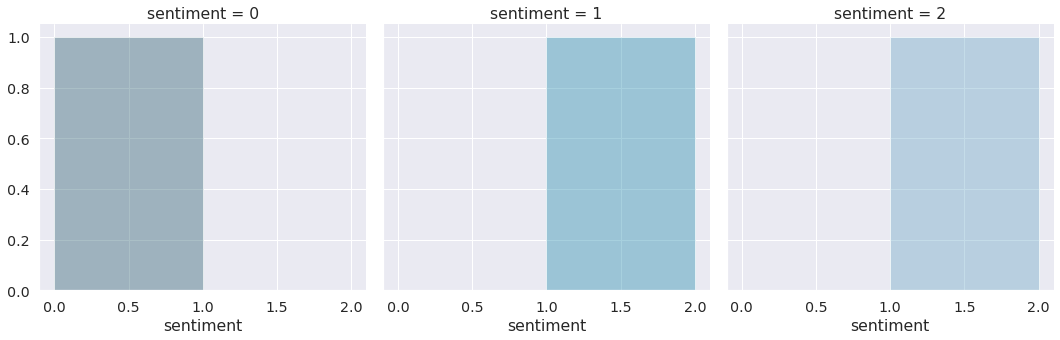

In [8]:
for i in df_eda.columns:
    show_dist(df_eda,i)

In [9]:
class CleanText(BaseEstimator, TransformerMixin):

    # Function for expanding contractions
    def expand_contractions(self, text):
        # Dictionary of English Contractions
        contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                             "can't": "cannot","can't've": "cannot have",
                             "'cause": "because","could've": "could have","couldn't": "could not",
                             "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                             "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                             "hasn't": "has not","haven't": "have not","he'd": "he would",
                             "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                             "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                             "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                             "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                             "it'd": "it would","it'd've": "it would have","it'll": "it will",
                             "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                             "mayn't": "may not","might've": "might have","mightn't": "might not", 
                             "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                             "mustn't've": "must not have", "needn't": "need not",
                             "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                             "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                             "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                             "she'll": "she will", "she'll've": "she will have","should've": "should have",
                             "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                             "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                             "there'd've": "there would have", "they'd": "they would",
                             "they'd've": "they would have","they'll": "they will",
                             "they'll've": "they will have", "they're": "they are","they've": "they have",
                             "to've": "to have","wasn't": "was not","we'd": "we would",
                             "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                             "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                             "what'll've": "what will have","what're": "what are", "what've": "what have",
                             "when've": "when have","where'd": "where did", "where've": "where have",
                             "who'll": "who will","who'll've": "who will have","who've": "who have",
                             "why've": "why have","will've": "will have","won't": "will not",
                             "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                             "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                             "y'all'd've": "you all would have","y'all're": "you all are",
                             "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                             "you'll": "you will","you'll've": "you will have", "you're": "you are",
                             "you've": "you have","would b":"would be"}
        # Regular expression for finding contractions
        contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
   
    def remove_mentions(self, input_text):
        input_text=text = re.sub(r'[\w]*sxsw[\w]*', '', input_text, flags=re.I)  #Removing sxsw hashtag
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words if word not in ['link','rt','sxsw','amp','quot','http','html']]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.expand_contractions).apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [10]:
ct = CleanText()
sr_clean = ct.fit_transform(df.tweet)
sr_clean.sample(5)

1399    stay away appl store tomorrow                           
6026    discuss salsa ingredi industri parti weliveher gsdm     
4613    anyon know appl store sell macbook batteri              
2338    anyon see visit temporari appl store                    
2921    pad new ubersoci iphon app store includ uberguid sponsor
Name: tweet, dtype: object

In [11]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


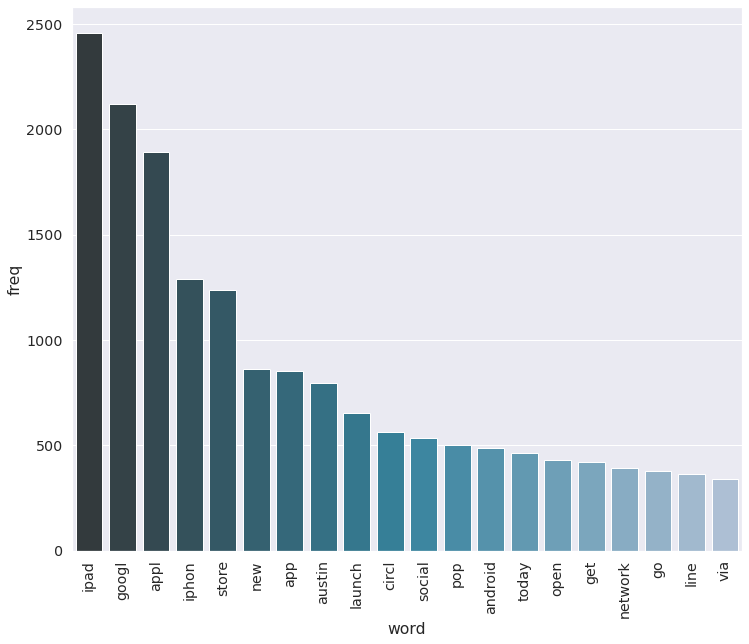

In [12]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.xticks(rotation=90)
plt.show();

In [13]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'sentiment',
 'clean_text']

In [14]:
df_model.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,clean_text
4559,12,0,0,0,0,0,0,1,googl launch major new social network call circl possibl today updat
770,13,0,0,0,0,0,0,2,spark select finalist team android choic award austin pleas come support
7160,8,0,0,0,0,0,0,2,ipad also cartoonishli larg digit camera csteja
6015,12,0,0,0,0,0,0,1,nicoriccelli googl launch major new social network call circl googl deni
5288,13,0,0,0,0,0,0,1,gsd googl industri parti tonight see austin weliveher gsdm


In [15]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model.drop('sentiment', axis=1), 
    df_model.sentiment, 
    test_size=0.2, 
    random_state=0
)

In [17]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    print("\nConfusion Matrix Test Data")
    print(confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [18]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [19]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [20]:
countvect = CountVectorizer()

In [21]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   35.8s finished


done in 37.777s

Best CV score: 0.674
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.669


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.78      0.07      0.12       105
           1       0.69      0.86      0.76       867
           2       0.61      0.45      0.52       483

    accuracy                           0.67      1455
   macro avg       0.69      0.46      0.47      1455
weighted avg       0.67      0.67      0.64      1455


Confusion Matrix Test Data
[[  7  77  21]
 [  2 747 118]
 [  0 264 219]]


In [22]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.1min finished


done in 193.589s

Best CV score: 0.693
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.697


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.79      0.14      0.24       105
           1       0.71      0.87      0.78       867
           2       0.65      0.51      0.57       483

    accuracy                           0.70      1455
   macro avg       0.72      0.51      0.53      1455
weighted avg       0.70      0.70      0.67      1455


Confusion Matrix Test Data
[[ 15  66  24]
 [  3 754 110]
 [  1 237 245]]


In [23]:
tfidfvect = TfidfVectorizer()

In [24]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   34.7s finished


done in 35.766s

Best CV score: 0.666
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.654


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.80      0.04      0.07       105
           1       0.68      0.86      0.76       867
           2       0.58      0.42      0.49       483

    accuracy                           0.65      1455
   macro avg       0.69      0.44      0.44      1455
weighted avg       0.65      0.65      0.62      1455


Confusion Matrix Test Data
[[  4  77  24]
 [  1 745 121]
 [  0 280 203]]


In [25]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.1min finished


done in 185.520s

Best CV score: 0.682
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.679


Classification Report Test Data
              precision    recall  f1-score   support

           0       1.00      0.06      0.11       105
           1       0.69      0.88      0.78       867
           2       0.63      0.45      0.52       483

    accuracy                           0.68      1455
   macro avg       0.77      0.46      0.47      1455
weighted avg       0.69      0.68      0.64      1455


Confusion Matrix Test Data
[[  6  74  25]
 [  0 766 101]
 [  0 267 216]]


In [26]:
SIZE = 25

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=3
                 , workers=4)

In [27]:
model.most_similar('plane', topn=3)

[('sun', 0.9963246583938599),
 ('result', 0.9959120154380798),
 ('got', 0.9958450794219971)]

In [28]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [29]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [30]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [31]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.8s finished


done in 4.175s

Best CV score: 0.601
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
Test score with best_estimator_: 0.593


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.60      0.97      0.74       867
           2       0.42      0.05      0.08       483

    accuracy                           0.59      1455
   macro avg       0.34      0.34      0.27      1455
weighted avg       0.50      0.59      0.47      1455


Confusion Matrix Test Data
[[  0 101   4]
 [  0 841  26]
 [  0 461  22]]


In [32]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=0.5, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('sentiment', axis=1), df_model.sentiment)

# on test data

In [33]:
data=pd.read_csv('Data/test.csv')
data['tweet']=data['tweet'].astype(str)

In [34]:
df_counts_pos = tc.transform(data.tweet)
df_clean_pos = ct.transform(data.tweet)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

pred=best_model.predict(df_model_pos).tolist()

In [35]:
pred

[1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,


In [36]:
output=pd.concat([data['tweet_id'],pd.DataFrame(pred,columns=['sentiment'])],axis=1)

In [37]:
output

,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,1
...,...,...
1814,1550,1
1815,1933,1
1816,9052,2
1817,4219,2


In [38]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   1819 non-null   int64
 1   sentiment  1819 non-null   int64
dtypes: int64(2)
memory usage: 28.5 KB


In [39]:
output.to_csv('Data/submission_file_v2.csv',index=False)